In [1]:
#A) Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import joblib

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_curve,
    auc
)

nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shweta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shweta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#B) Load Dataset + Basic Inspection

In [4]:
df = pd.read_excel("drugsCom_raw.xlsx")

print(df.shape)
df.head()


(161297, 7)


,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


In [5]:
df.info()
df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Unnamed: 0   161297 non-null  int64         
 1   drugName     161297 non-null  object        
 2   condition    160398 non-null  object        
 3   review       161297 non-null  object        
 4   rating       161297 non-null  int64         
 5   date         161297 non-null  datetime64[ns]
 6   usefulCount  161297 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 8.6+ MB


Index(['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')

In [6]:
#C) Missing Values

In [7]:
df.isnull().sum()


Unnamed: 0       0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [8]:
#D) Drop Missing review + condition

In [9]:
df = df.dropna(subset=["review", "condition"])
df.isnull().sum()


Unnamed: 0     0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [10]:
#E) Keep only 3 conditions

In [11]:
target_conditions = ["Depression", "High Blood Pressure", "Diabetes, Type 2"]

df = df[df["condition"].isin(target_conditions)]
df["condition"].value_counts()


condition
Depression             9069
Diabetes, Type 2       2554
High Blood Pressure    2321
Name: count, dtype: int64

In [12]:
#2) EDA + VISUALIZATIONS

In [13]:
##Condition Distribution

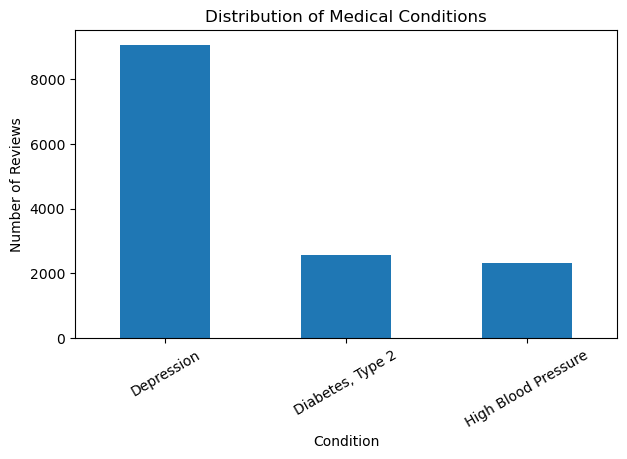

In [14]:
plt.figure(figsize=(7,4))
df["condition"].value_counts().plot(kind="bar")
plt.title("Distribution of Medical Conditions")
plt.xlabel("Condition")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=30)
plt.show()


In [15]:
##Unique drugs overall + per condition

In [16]:
print("Total unique drugs:", df["drugName"].nunique())
df.groupby("condition")["drugName"].nunique()


Total unique drugs: 334


condition
Depression             105
Diabetes, Type 2        89
High Blood Pressure    140
Name: drugName, dtype: int64

In [17]:
##Top 15 most reviewed drugs

In [18]:
df["drugName"].value_counts().head(15)


drugName
Bupropion         549
Sertraline        459
Venlafaxine       437
Pristiq           418
Desvenlafaxine    414
Citalopram        388
Escitalopram      380
Vortioxetine      345
Duloxetine        328
Vilazodone        315
Lexapro           306
Cymbalta          303
Fluoxetine        302
Viibryd           285
Zoloft            281
Name: count, dtype: int64

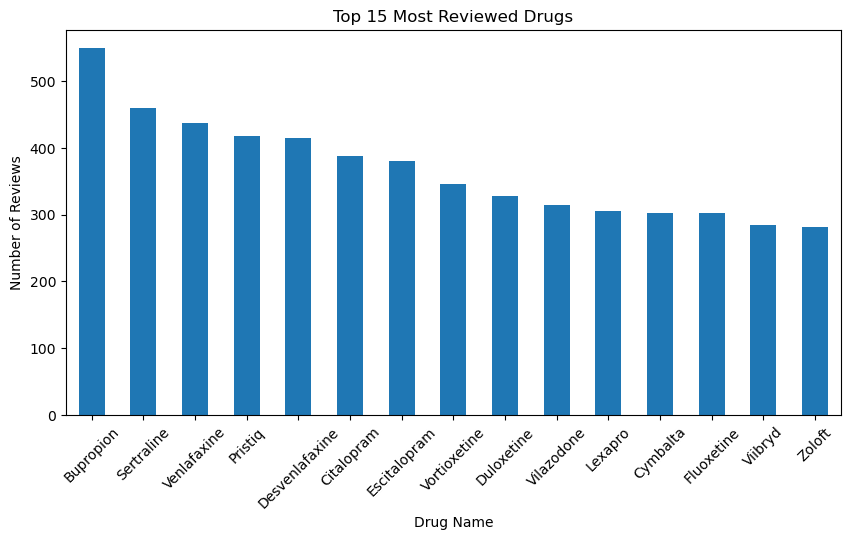

In [19]:
plt.figure(figsize=(10,5))
df["drugName"].value_counts().head(15).plot(kind="bar")
plt.title("Top 15 Most Reviewed Drugs")
plt.xlabel("Drug Name")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.show()


In [20]:
##Top drugs per condition

In [21]:
for cond in target_conditions:
    print(f"\nTop drugs used for {cond}:")
    print(df[df["condition"] == cond]["drugName"].value_counts().head(5))



Top drugs used for Depression:
drugName
Bupropion         549
Sertraline        459
Venlafaxine       437
Pristiq           418
Desvenlafaxine    414
Name: count, dtype: int64

Top drugs used for High Blood Pressure:
drugName
Lisinopril    264
Losartan      166
Amlodipine    153
Nebivolol     110
Bystolic       99
Name: count, dtype: int64

Top drugs used for Diabetes, Type 2:
drugName
Liraglutide    270
Victoza        255
Dulaglutide    231
Trulicity      221
Exenatide      192
Name: count, dtype: int64


In [22]:
##Rating distribution across conditions

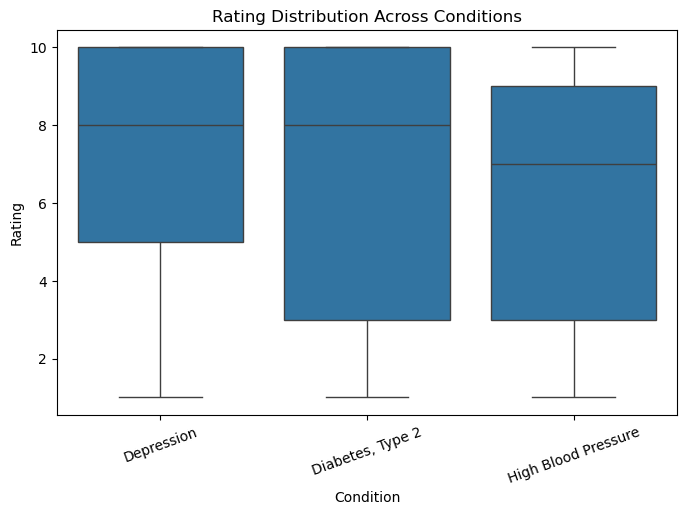

In [23]:
plt.figure(figsize=(8,5))
sns.boxplot(x="condition", y="rating", data=df)
plt.title("Rating Distribution Across Conditions")
plt.xlabel("Condition")
plt.ylabel("Rating")
plt.xticks(rotation=20)
plt.show()


In [24]:
##Best rated drugs (with minimum reviews)

In [25]:
drug_stats = df.groupby("drugName").agg(
    avg_rating=("rating", "mean"),
    total_reviews=("rating", "count")
)

drug_stats = drug_stats[drug_stats["total_reviews"] >= 30]
drug_stats.sort_values("avg_rating", ascending=False).head(10)


,avg_rating,total_reviews
drugName,,
Tramadol,9.288462,52
Xanax,9.166667,42
Alprazolam,9.081967,61
Azor,8.850000,40
St. john's wort,8.767442,43
Parnate,8.763158,38
Amlodipine / olmesartan,8.735294,34
Amitriptyline,8.552632,38
Tranylcypromine,8.526316,38


In [26]:
#3) SENTIMENT (from rating)

In [27]:
def rating_to_sentiment(rating):
    if rating >= 7:
        return "Positive"
    elif rating <= 4:
        return "Negative"
    else:
        return "Neutral"

df["sentiment"] = df["rating"].apply(rating_to_sentiment)
df["sentiment"].value_counts()


sentiment
Positive    9021
Negative    3487
Neutral     1436
Name: count, dtype: int64

In [28]:
##Sentiment distribution plot

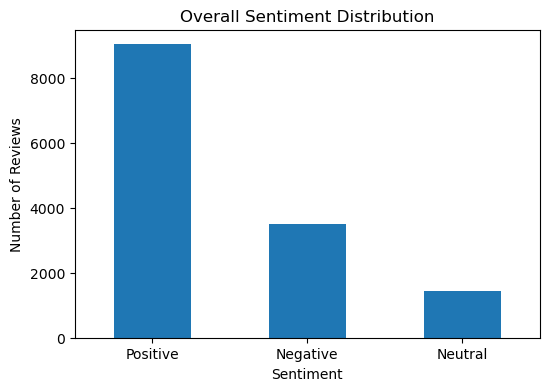

In [29]:
plt.figure(figsize=(6,4))
df["sentiment"].value_counts().plot(kind="bar")
plt.title("Overall Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.show()


In [30]:
##Sentiment across conditions

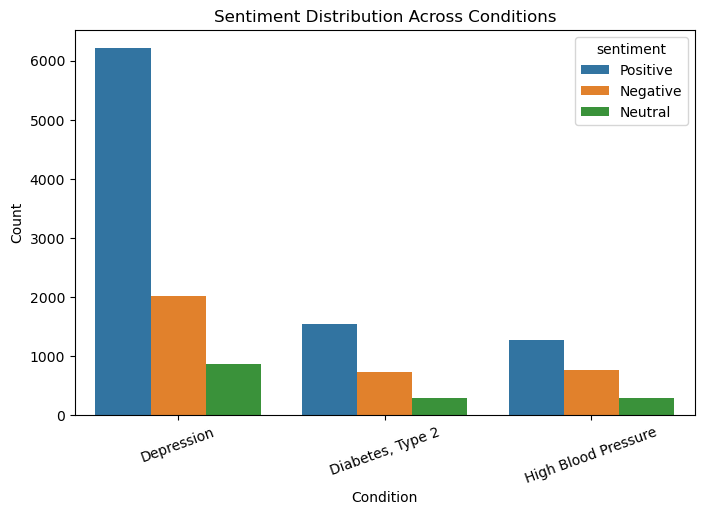

In [31]:
plt.figure(figsize=(8,5))
sns.countplot(x="condition", hue="sentiment", data=df)
plt.title("Sentiment Distribution Across Conditions")
plt.xlabel("Condition")
plt.ylabel("Count")
plt.xticks(rotation=20)
plt.show()


In [32]:
##Sentiment for Top 5 drugs

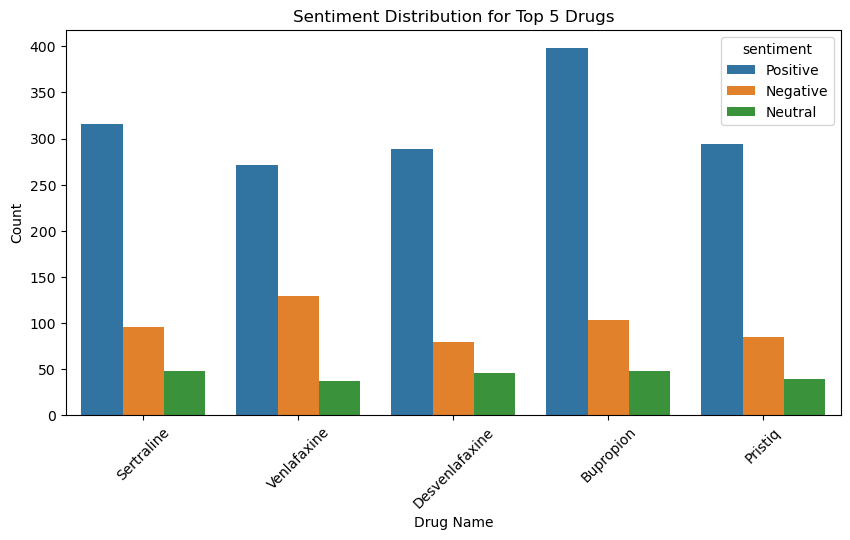

In [33]:
top_drugs = df["drugName"].value_counts().head(5).index
df_top_drugs = df[df["drugName"].isin(top_drugs)]

plt.figure(figsize=(10,5))
sns.countplot(x="drugName", hue="sentiment", data=df_top_drugs)
plt.title("Sentiment Distribution for Top 5 Drugs")
plt.xlabel("Drug Name")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [34]:
#4) REVIEW LENGTH ANALYSIS

In [35]:
df["review_length"] = df["review"].str.len()
df["review_length"].describe()


count    13944.000000
mean       455.965792
std        244.109678
min          6.000000
25%        256.000000
50%        451.000000
75%        691.000000
max       3249.000000
Name: review_length, dtype: float64

In [36]:
##Histogram

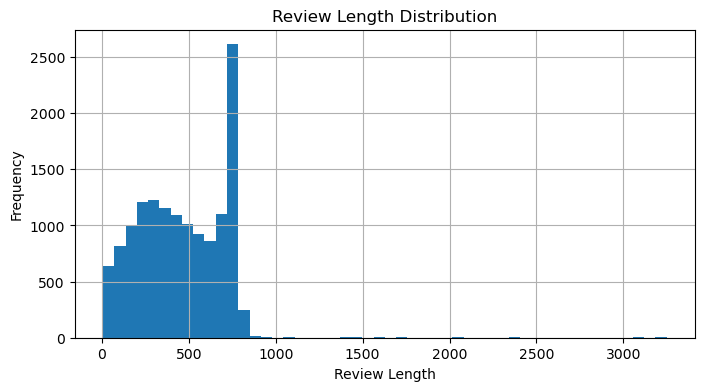

In [37]:
plt.figure(figsize=(8,4))
df["review_length"].hist(bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.show()


In [38]:
##Review length vs sentiment

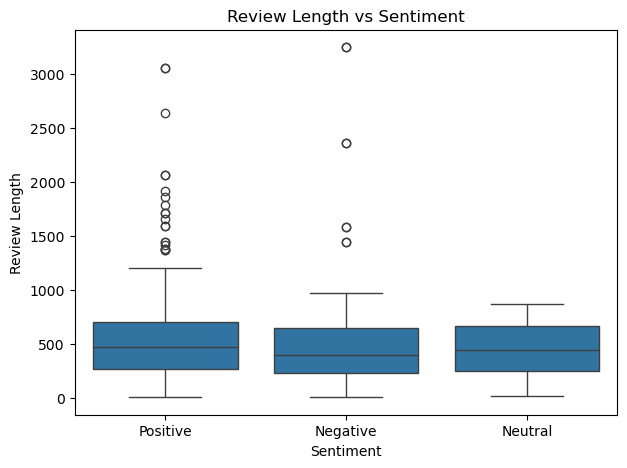

In [39]:
plt.figure(figsize=(7,5))
sns.boxplot(x="sentiment", y="review_length", data=df)
plt.title("Review Length vs Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Review Length")
plt.show()


In [40]:
#5) TEXT CLEANING (same flow)

In [41]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)  # keep numbers
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df["clean_review"] = df["review"].apply(clean_text)
df[["review", "clean_review"]].head()


,review,clean_review
11,"""I have taken anti-depressants for years, with...",taken anti depressant year improvement mostly ...
31,"""1 week on Zoloft for anxiety and mood swings....",1 week zoloft anxiety mood swing take 50mg mor...
44,"""my gp started me on Venlafaxine yesterday to ...",gp started venlafaxine yesterday help depressi...
50,"""Hey Guys, It&#039;s been 4 months since my l...",hey guy 039 4 month since last post wanted giv...
67,"""This medicine saved my life. I was at my wits...",medicine saved life wit end anti depressant re...


In [42]:
#6) WORDCLOUDS (Condition-wise)

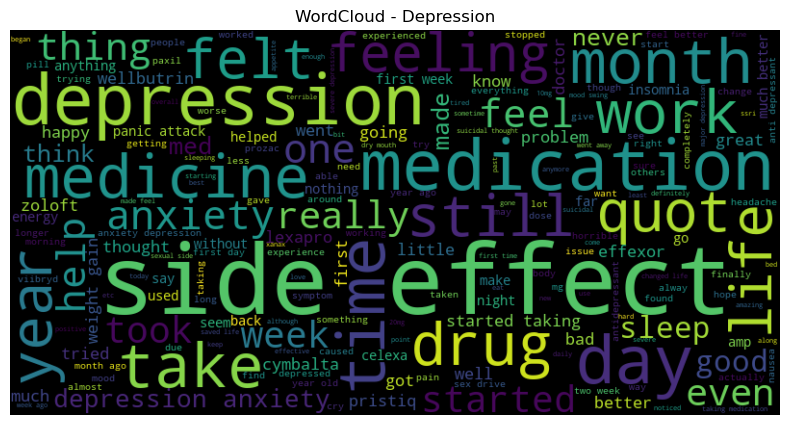

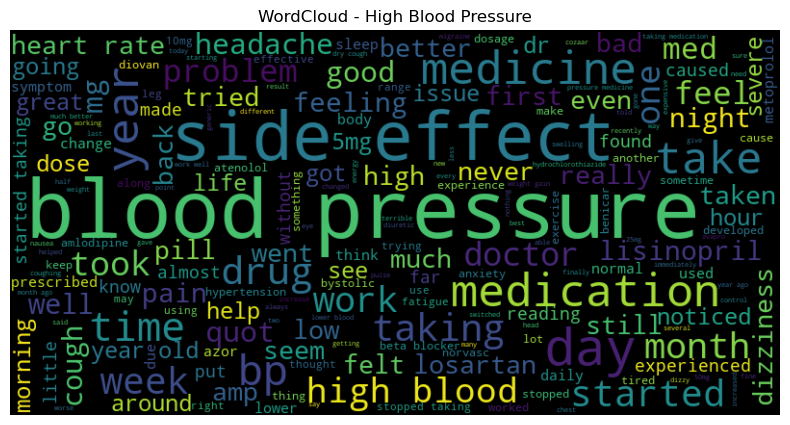

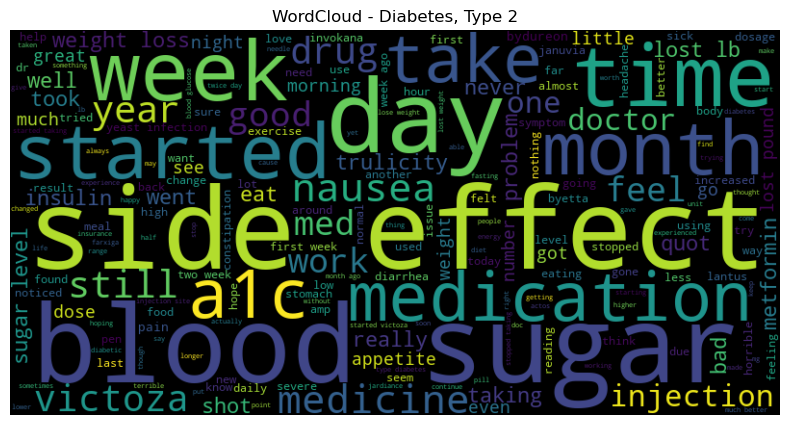

In [44]:
for cond in target_conditions:
    text = " ".join(df[df["condition"] == cond]["clean_review"])
    wc = WordCloud(width=800, height=400, background_color="black").generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - {cond}")
    plt.show()


In [45]:
#7) WORDCLOUDS (Sentiment-wise)

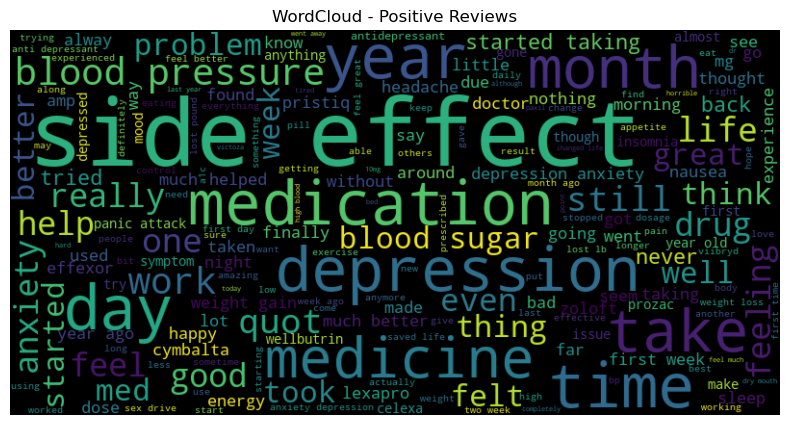

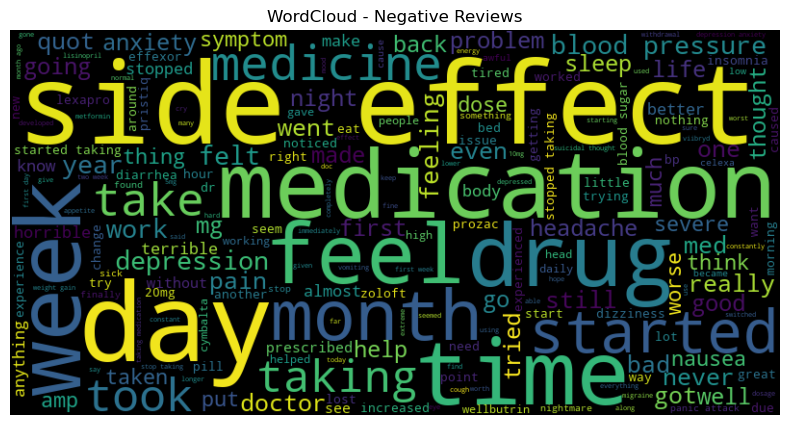

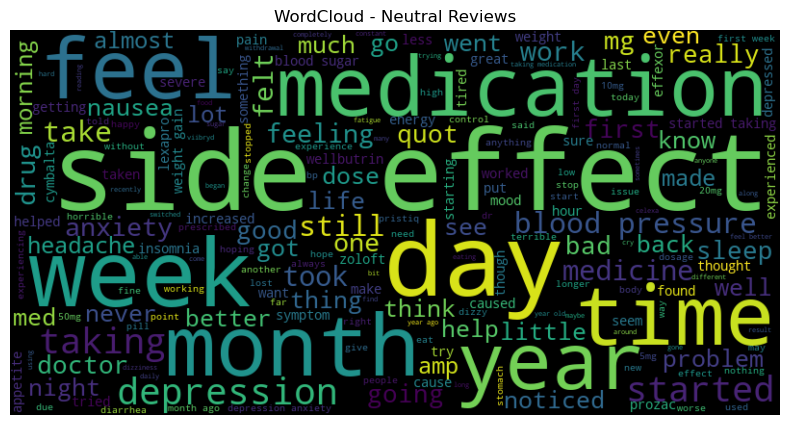

In [46]:
for sent in ["Positive", "Negative", "Neutral"]:
    text = " ".join(df[df["sentiment"] == sent]["clean_review"])
    wc = WordCloud(width=800, height=400, background_color="black").generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - {sent} Reviews")
    plt.show()


In [47]:
#8) TRAIN TEST SPLIT + TF-IDF

In [48]:
X = df["clean_review"]
y = df["condition"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [49]:
#9) LABEL ENCODER

In [50]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

dict(zip(le.classes_, le.transform(le.classes_)))


{'Depression': np.int64(0),
 'Diabetes, Type 2': np.int64(1),
 'High Blood Pressure': np.int64(2)}

In [51]:
#10) MODEL EVALUATION FUNCTION

In [52]:
def evaluate_model(model, X_test, y_test, y_pred, name):
    acc = accuracy_score(y_test, y_pred)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted"
    )

    print(f"\n{name} Results")
    print("Accuracy:", acc)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    return acc, precision, recall, f1


In [53]:
#11) Train Multiple Models

In [54]:
results = []


In [55]:
#Logistic Regression

In [56]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train_enc)

y_pred_lr = lr.predict(X_test_tfidf)
results.append(("Logistic Regression", *evaluate_model(lr, X_test_tfidf, y_test_enc, y_pred_lr, "Logistic Regression")))



Logistic Regression Results
Accuracy: 0.9508784510577268
Precision: 0.951311483559922
Recall: 0.9508784510577268
F1 Score: 0.9498279587208688


In [57]:
#Naive Bayes

In [58]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train_enc)

y_pred_nb = nb.predict(X_test_tfidf)
results.append(("Naive Bayes", *evaluate_model(nb, X_test_tfidf, y_test_enc, y_pred_nb, "Naive Bayes")))



Naive Bayes Results
Accuracy: 0.947292936536393
Precision: 0.9477269298562387
Recall: 0.947292936536393
F1 Score: 0.9462280480563572


In [59]:
#Linear SVM (BEST)

In [60]:
svm = LinearSVC(class_weight="balanced")  # IMPORTANT FIX
svm.fit(X_train_tfidf, y_train_enc)

y_pred_svm = svm.predict(X_test_tfidf)
results.append(("Linear SVM", *evaluate_model(svm, X_test_tfidf, y_test_enc, y_pred_svm, "Linear SVM")))



Linear SVM Results
Accuracy: 0.9637863033345285
Precision: 0.9635768044179357
Recall: 0.9637863033345285
F1 Score: 0.9636009136783371


In [61]:
#Random Forest

In [62]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_tfidf, y_train_enc)

y_pred_rf = rf.predict(X_test_tfidf)
results.append(("Random Forest", *evaluate_model(rf, X_test_tfidf, y_test_enc, y_pred_rf, "Random Forest")))



Random Forest Results
Accuracy: 0.9591251344567946
Precision: 0.9593962390797819
Recall: 0.9591251344567946
F1 Score: 0.9584722216423194


In [63]:
#Gradient Boosting

In [66]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_tfidf.toarray(), y_train_enc)

y_pred_gb = gb.predict(X_test_tfidf.toarray())
results.append(("Gradient Boosting", *evaluate_model(gb, X_test_tfidf.toarray(), y_test_enc, y_pred_gb, "Gradient Boosting")))



Gradient Boosting Results
Accuracy: 0.9232699892434565
Precision: 0.9270378435482102
Recall: 0.9232699892434565
F1 Score: 0.9206208839412792


In [67]:
#12) Model Comparison Table

In [68]:
results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"]
)

results_df.sort_values(by="F1 Score", ascending=False)


,Model,Accuracy,Precision,Recall,F1 Score
2,Linear SVM,0.963786,0.963577,0.963786,0.963601
3,Random Forest,0.959125,0.959396,0.959125,0.958472
0,Logistic Regression,0.950878,0.951311,0.950878,0.949828
1,Naive Bayes,0.947293,0.947727,0.947293,0.946228
4,Gradient Boosting,0.923270,0.927038,0.923270,0.920621
5,Gradient Boosting,0.923270,0.927038,0.923270,0.920621


In [69]:
#13) Best Model Selection

In [70]:
best_model = svm


In [71]:
#14) Confusion Matrix (Best Model)

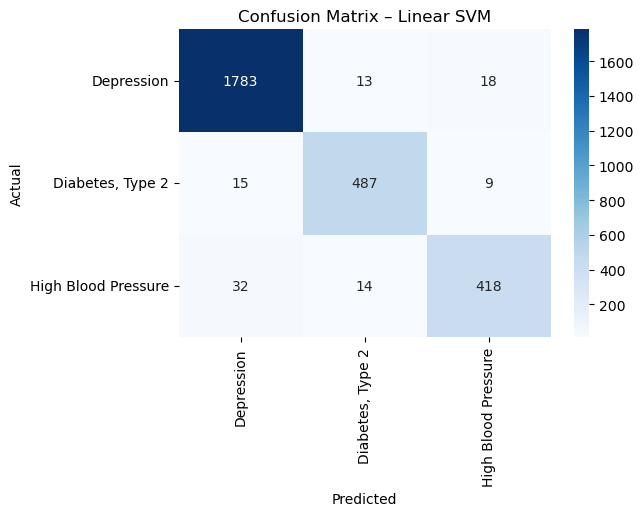

In [72]:
cm = confusion_matrix(y_test_enc, y_pred_svm)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Linear SVM")
plt.show()


In [73]:
#15) ROC Curve (OvR) for Linear SVM

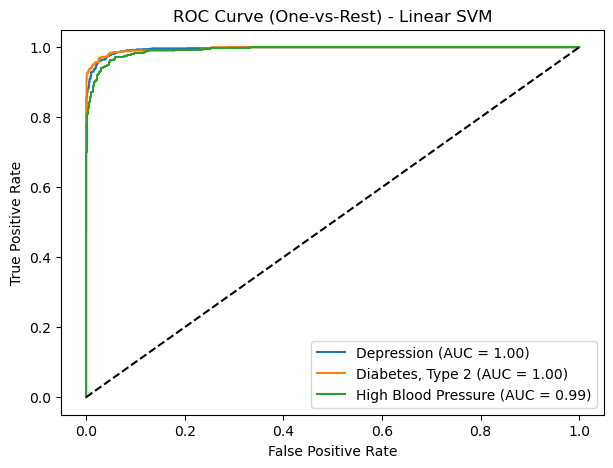

In [74]:
y_test_bin = label_binarize(y_test_enc, classes=[0, 1, 2])
y_score = svm.decision_function(X_test_tfidf)

plt.figure(figsize=(7,5))

for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest) - Linear SVM")
plt.legend(loc="lower right")
plt.show()


In [75]:
#16) GridSearchCV for Best SVM

In [76]:
param_grid = {"C": [0.01, 0.1, 1, 10]}

svm_grid = GridSearchCV(
    LinearSVC(class_weight="balanced"),
    param_grid,
    scoring="f1_weighted",
    cv=3,
    n_jobs=-1
)

svm_grid.fit(X_train_tfidf, y_train_enc)

print("Best Params:", svm_grid.best_params_)
best_svm = svm_grid.best_estimator_


Best Params: {'C': 1}


In [77]:
#17) Best Tuned SVM Report

In [78]:
y_pred_best_svm = best_svm.predict(X_test_tfidf)

print(classification_report(
    y_test_enc,
    y_pred_best_svm,
    target_names=le.classes_
))


                     precision    recall  f1-score   support

         Depression       0.97      0.98      0.98      1814
   Diabetes, Type 2       0.95      0.95      0.95       511
High Blood Pressure       0.94      0.90      0.92       464

           accuracy                           0.96      2789
          macro avg       0.95      0.95      0.95      2789
       weighted avg       0.96      0.96      0.96      2789



In [79]:
#18) Drug Recommendation System (Top 5)

In [80]:
drug_reco = {}

for cond in target_conditions:
    cond_df = df[df["condition"] == cond]

    drug_stats = cond_df.groupby("drugName").agg(
        avg_rating=("rating", "mean"),
        total_reviews=("rating", "count")
    )

    drug_stats = drug_stats[drug_stats["total_reviews"] >= 30]
    drug_stats = drug_stats.sort_values("avg_rating", ascending=False)

    drug_reco[cond] = drug_stats.head(5).index.tolist()

drug_reco


{'Depression': ['Tramadol',
  'Xanax',
  'Alprazolam',
  "St. john's wort",
  'Parnate'],
 'High Blood Pressure': ['Azor',
  'Amlodipine / olmesartan',
  'Olmesartan',
  'Benicar',
  'Hydrochlorothiazide / lisinopril'],
 'Diabetes, Type 2': ['Byetta',
  'Victoza',
  'Liraglutide',
  'Glimepiride',
  'Insulin glargine']}

In [81]:
#19) Rule Based Sentiment for User Input

In [82]:
def get_sentiment_from_text(text):
    positive_words = [
        "good", "better", "helped", "effective", "relief",
        "improved", "happy", "works", "controlled"
    ]

    negative_words = [
        "bad", "worse", "pain", "side effect", "headache",
        "nausea", "dizzy", "weak", "tired", "problem",
        "did not help", "not help", "no relief"
    ]

    text = text.lower()

    pos_count = sum(word in text for word in positive_words)
    neg_count = sum(word in text for word in negative_words)

    if pos_count > neg_count:
        return "Positive"
    elif neg_count > pos_count:
        return "Negative"
    else:
        return "Neutral"


In [83]:
#20) Combined Prediction Function

In [84]:
def predict_review(review_text):
    cleaned = clean_text(review_text)
    vectorized = tfidf.transform([cleaned])

    condition_pred = best_svm.predict(vectorized)
    condition = le.inverse_transform(condition_pred)[0]

    sentiment = get_sentiment_from_text(review_text)

    recommended_drugs = drug_reco.get(condition, [])

    return sentiment, condition, recommended_drugs


In [85]:
#21) Test Input

In [86]:
test_review = "I have severe headache and low BP. The medicine did not help me."

sentiment, condition, drugs = predict_review(test_review)

print("Review:", test_review)
print("Sentiment:", sentiment)
print("Predicted Condition:", condition)
print("Recommended Drugs:", drugs)


Review: I have severe headache and low BP. The medicine did not help me.
Sentiment: Negative
Predicted Condition: High Blood Pressure
Recommended Drugs: ['Azor', 'Amlodipine / olmesartan', 'Olmesartan', 'Benicar', 'Hydrochlorothiazide / lisinopril']


In [87]:
#22) Save Everything

In [89]:
joblib.dump(best_svm, "svm_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")
joblib.dump(drug_reco, "drug_recommendations.pkl")

print(" All objects saved successfully!")


 All objects saved successfully!
